In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNet import ghost_net
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": "ghost",
    "module_alias": "GhostNet",
    "data_path": "/Users/leo/Programming/Thesis/data/ImageNet_100/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 100,
    "epochs": 25,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"], module_type = prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/1cc807f1c16e4097bc046075930ed33a



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


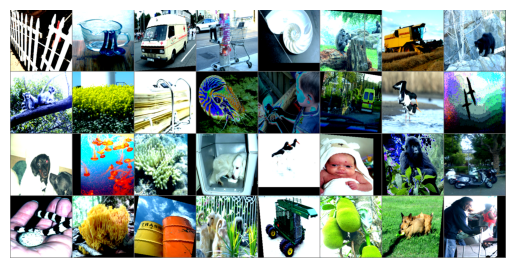

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNet (GhostNet)                                     [1, 3, 224, 224]     [1, 100]             --                   --                   --                   True
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                   [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                             [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --                   32                   True

100%|██████████| 377/377 [01:09<00:00,  5.39it/s]


Epoch: 01 | Epoch Time: 18.0m 0s
	Train Loss: 3.955 | Train Acc: 11.08%
	 Val. Loss: 3.127 |  Val. Acc: 23.65%
Best Accuracy Achieved: 23.65% on epoch 01


100%|██████████| 377/377 [01:10<00:00,  5.35it/s]


Epoch: 02 | Epoch Time: 18.0m 15s
	Train Loss: 3.075 | Train Acc: 24.77%
	 Val. Loss: 2.565 |  Val. Acc: 34.74%
Best Accuracy Achieved: 34.74% on epoch 02


100%|██████████| 377/377 [01:09<00:00,  5.45it/s]


Epoch: 03 | Epoch Time: 17.0m 41s
	Train Loss: 2.579 | Train Acc: 35.06%
	 Val. Loss: 2.247 |  Val. Acc: 42.37%
Best Accuracy Achieved: 42.37% on epoch 03


100%|██████████| 377/377 [01:10<00:00,  5.31it/s]


Epoch: 04 | Epoch Time: 18.0m 3s
	Train Loss: 2.266 | Train Acc: 41.98%
	 Val. Loss: 1.934 |  Val. Acc: 49.23%
Best Accuracy Achieved: 49.23% on epoch 04


100%|██████████| 377/377 [01:11<00:00,  5.26it/s]


Epoch: 05 | Epoch Time: 19.0m 30s
	Train Loss: 2.048 | Train Acc: 46.97%
	 Val. Loss: 1.841 |  Val. Acc: 51.35%
Best Accuracy Achieved: 51.35% on epoch 05


100%|██████████| 377/377 [01:09<00:00,  5.41it/s]


Epoch: 06 | Epoch Time: 18.0m 8s
	Train Loss: 1.876 | Train Acc: 50.88%
	 Val. Loss: 1.732 |  Val. Acc: 54.53%
Best Accuracy Achieved: 54.53% on epoch 06


100%|██████████| 377/377 [01:09<00:00,  5.41it/s]


Epoch: 07 | Epoch Time: 17.0m 53s
	Train Loss: 1.735 | Train Acc: 54.26%
	 Val. Loss: 1.613 |  Val. Acc: 58.26%
Best Accuracy Achieved: 58.26% on epoch 07


100%|██████████| 377/377 [01:11<00:00,  5.24it/s]


Epoch: 08 | Epoch Time: 18.0m 5s
	Train Loss: 1.625 | Train Acc: 56.90%
	 Val. Loss: 1.513 |  Val. Acc: 60.32%
Best Accuracy Achieved: 60.32% on epoch 08


100%|██████████| 377/377 [01:08<00:00,  5.53it/s]


Epoch: 09 | Epoch Time: 17.0m 57s
	Train Loss: 1.520 | Train Acc: 59.42%
	 Val. Loss: 1.486 |  Val. Acc: 61.14%
Best Accuracy Achieved: 61.14% on epoch 09


100%|██████████| 377/377 [01:11<00:00,  5.28it/s]


Epoch: 10 | Epoch Time: 18.0m 45s
	Train Loss: 1.441 | Train Acc: 61.22%
	 Val. Loss: 1.538 |  Val. Acc: 59.94%


100%|██████████| 377/377 [01:07<00:00,  5.62it/s]


Epoch: 11 | Epoch Time: 18.0m 4s
	Train Loss: 1.356 | Train Acc: 63.24%
	 Val. Loss: 1.458 |  Val. Acc: 61.64%
Best Accuracy Achieved: 61.64% on epoch 11


100%|██████████| 377/377 [01:10<00:00,  5.35it/s]


Epoch: 12 | Epoch Time: 18.0m 0s
	Train Loss: 1.286 | Train Acc: 64.79%
	 Val. Loss: 1.400 |  Val. Acc: 63.23%
Best Accuracy Achieved: 63.23% on epoch 12


100%|██████████| 377/377 [01:09<00:00,  5.46it/s]


Epoch: 13 | Epoch Time: 17.0m 52s
	Train Loss: 1.221 | Train Acc: 66.48%
	 Val. Loss: 1.412 |  Val. Acc: 63.37%
Best Accuracy Achieved: 63.37% on epoch 13


100%|██████████| 377/377 [01:09<00:00,  5.43it/s]


Epoch: 14 | Epoch Time: 17.0m 48s
	Train Loss: 1.161 | Train Acc: 67.89%
	 Val. Loss: 1.382 |  Val. Acc: 64.73%
Best Accuracy Achieved: 64.73% on epoch 14


100%|██████████| 377/377 [01:09<00:00,  5.43it/s]


Epoch: 15 | Epoch Time: 17.0m 48s
	Train Loss: 1.115 | Train Acc: 68.92%
	 Val. Loss: 1.342 |  Val. Acc: 66.04%
Best Accuracy Achieved: 66.04% on epoch 15


100%|██████████| 377/377 [01:09<00:00,  5.44it/s]


Epoch: 16 | Epoch Time: 17.0m 44s
	Train Loss: 1.065 | Train Acc: 70.32%
	 Val. Loss: 1.410 |  Val. Acc: 64.64%


100%|██████████| 377/377 [01:09<00:00,  5.42it/s]


Epoch: 17 | Epoch Time: 17.0m 49s
	Train Loss: 1.015 | Train Acc: 71.37%
	 Val. Loss: 1.393 |  Val. Acc: 65.22%


100%|██████████| 377/377 [01:09<00:00,  5.44it/s]


Epoch: 18 | Epoch Time: 17.0m 46s
	Train Loss: 0.966 | Train Acc: 72.69%
	 Val. Loss: 1.335 |  Val. Acc: 66.84%
Best Accuracy Achieved: 66.84% on epoch 18


100%|██████████| 377/377 [01:07<00:00,  5.54it/s]


Epoch: 19 | Epoch Time: 17.0m 44s
	Train Loss: 0.928 | Train Acc: 73.60%
	 Val. Loss: 1.404 |  Val. Acc: 66.18%


100%|██████████| 377/377 [01:03<00:00,  5.95it/s]


Epoch: 20 | Epoch Time: 17.0m 43s
	Train Loss: 0.891 | Train Acc: 74.58%
	 Val. Loss: 1.391 |  Val. Acc: 65.61%


100%|██████████| 377/377 [01:09<00:00,  5.44it/s]


Epoch: 21 | Epoch Time: 17.0m 48s
	Train Loss: 0.859 | Train Acc: 75.38%
	 Val. Loss: 1.406 |  Val. Acc: 66.87%
Best Accuracy Achieved: 66.87% on epoch 21


100%|██████████| 377/377 [01:07<00:00,  5.55it/s]


Epoch: 22 | Epoch Time: 17.0m 38s
	Train Loss: 0.827 | Train Acc: 76.26%
	 Val. Loss: 1.459 |  Val. Acc: 65.75%


100%|██████████| 377/377 [01:07<00:00,  5.57it/s]


Epoch: 23 | Epoch Time: 17.0m 16s
	Train Loss: 0.794 | Train Acc: 76.96%
	 Val. Loss: 1.448 |  Val. Acc: 65.67%


100%|██████████| 377/377 [01:07<00:00,  5.60it/s]


Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 24 | Epoch Time: 17.0m 20s
	Train Loss: 0.765 | Train Acc: 77.78%
	 Val. Loss: 1.395 |  Val. Acc: 67.00%
Best Accuracy Achieved: 67.00% on epoch 24


100%|██████████| 377/377 [01:04<00:00,  5.87it/s]


Epoch: 25 | Epoch Time: 16.0m 47s
	Train Loss: 0.461 | Train Acc: 86.58%
	 Val. Loss: 1.387 |  Val. Acc: 69.69%
Best Accuracy Achieved: 69.69% on epoch 25


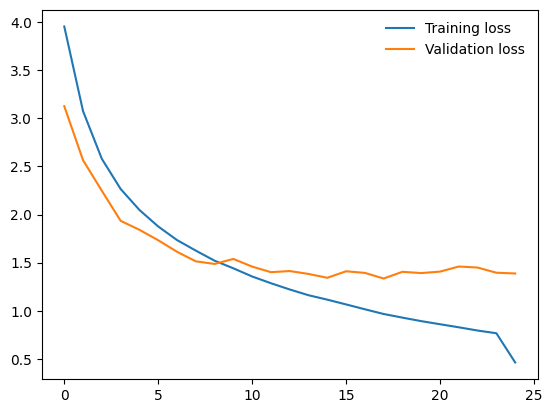

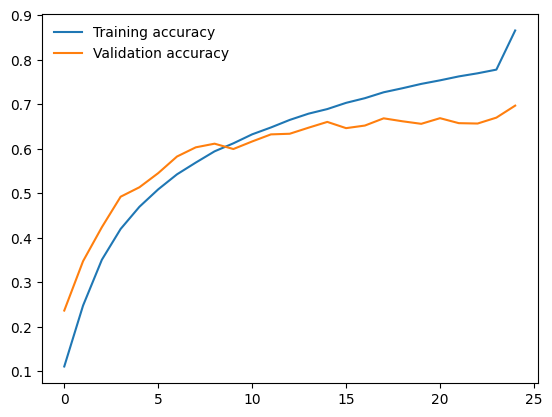

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

Test loss: 1.437.. 
Test accuracy: 0.692
Test Time: 1.0m 6s 421ms


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/1cc807f1c16e4097bc046075930ed33a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     flops           : 45837240.0
COMET INFO:     inference_time  : 0.0055162525287885105
COMET INFO:     loss [7522]     : (-5.955726623535156, 8.601448059082031)
COMET INFO:     params          : 1593418.0
COMET INFO:     test_accuracy   : 0.6920521259307861
COMET INFO:     test_loss       : 1.4366279143984557
COMET INFO:     train_acc [25]  : (0.11084015667438507, 0.8657954335212708)
COMET INFO:     train_loss [25] : (0.4613755559505837, 3.955450296565962)
COMET INFO:     val_acc [25]    : (0.23648424446582794, 0.6969

(1.4366279143984557, tensor(0.6921, device='mps:0'))